In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Assignment 6
### Problem 1

In [2]:
link = "https://raw.githubusercontent.com/sievers/phys512-2020/master/problem_sets/rand_points.txt"
x,y,z = np.loadtxt(link, unpack = True)

#### 3D plot of the triples

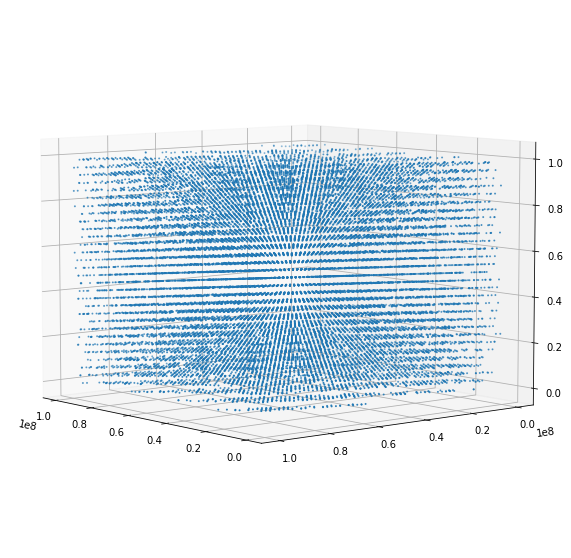

In [3]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, '.', s = 1)
ax.view_init(elev=6.5, azim=140.3)

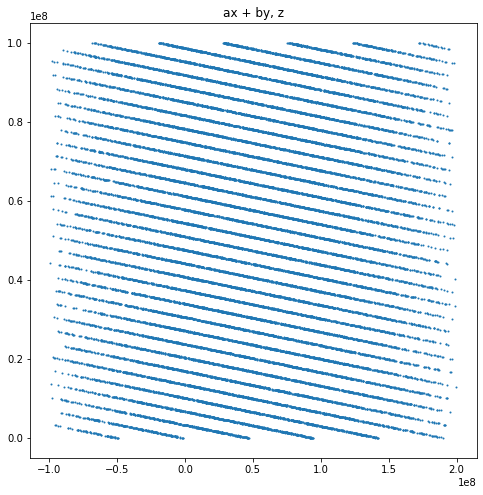

In [4]:
a = 2.
b = -1.
plt.figure(figsize = (8,8))
plt.scatter(a*x + b*y, z, s = 1)
plt.title('ax + by, z')
plt.show()

### Using numpy.random

In [5]:
n = 30000
vec = np.random.randint(0, 10**8, n*3)
vv = np.reshape(vec,[n,3])

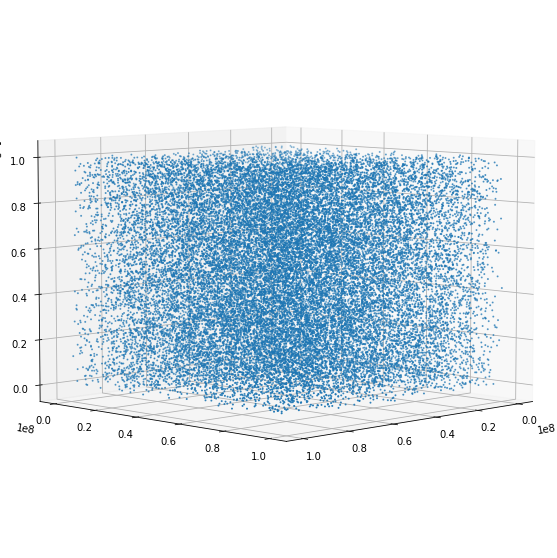

In [6]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vv[:,0], vv[:,1], vv[:,2], '.', s = 1)
ax.view_init(elev=6, azim=45)

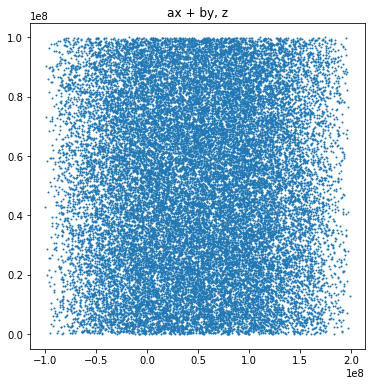

In [7]:
a = 2.
b = -1.
plt.figure(figsize = (6,6))
plt.scatter(a*vv[:,0] + b*vv[:,1], vv[:,2], s = 1)
plt.title('ax + by, z')
plt.show()

We don't see the same effect using the numpy random number generator.

I didn't manage to reproduce the effect with C rand() on my computer.

## Problem 2

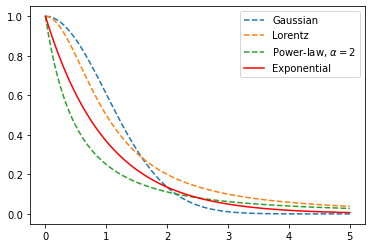

In [8]:
### illustration for choosing the bounding PDF
# PDFs are not normalized - doesn't matter for rejection method

def lorentz_pdf(x):
    return 1./(1.+x**2)

def gauss_pdf(x, m = 0, sig = 1.):
    return np.exp(-0.5*(x - m)**2/sig**2)

# power-law distributions are usually defined on [1, inf]
# so shift x
def power_pdf(x, alpha = 2):
    return 1./(x+1.)**alpha 

# for the exponential, take lambda = 1
# as it is just a matter of rescaling x
def exp_pdf(x, exp_lambda = 1.): 
    return exp_lambda*np.exp(-exp_lambda*x)

xx = np.linspace(0, 5., 101)
plt.plot(xx, gauss_pdf(xx), '--', label = 'Gaussian')
plt.plot(xx, lorentz_pdf(xx), '--', label = 'Lorentz')
plt.plot(xx, power_pdf(xx,2), '--', label = r'Power-law, $\alpha = 2$')
plt.plot(xx, exp_pdf(xx), 'r-', label = 'Exponential')
plt.legend(); plt.show()

The tails of the exponential distribution decay slower than the Gaussian distribution, but faster than the Lorentzian or power-law distributions.


So for the bounding distribution, we can use the Lorentzian as it is always higher than the exponential distribution, or we can use the power-law distributions after multiplying them by a constant.

In [9]:
print(np.max(exp_pdf(xx)/power_pdf(xx,2)))

1.4715177646857693


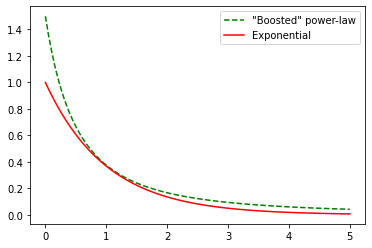

In [10]:
# so if we take a power-law distribution (alpha=2) we should multiply by ~1.5
plt.plot(xx, 1.5*power_pdf(xx,2), 'g--', label = '"Boosted" power-law')
plt.plot(xx, exp_pdf(xx), 'r-', label = 'Exponential')
plt.legend()
plt.show()

Acceptance rate = 0.637


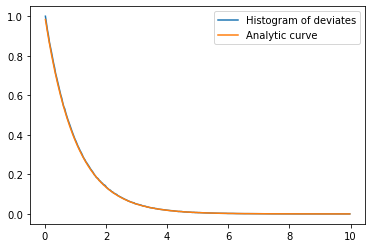

In [11]:
# rejection method using a Lorentzian
def lorentz_sample(n): # using a CDF
    r = np.random.rand(n)
    return np.tan(np.pi*(r - 0.5))

def exp_sample_from_lorentz(x): # x is an array of Lorentzian deviates
    prob = exp_pdf(x)/lorentz_pdf(x)
    assert(np.max(prob) <= 1) 
    accepted = np.random.rand(len(x)) < prob
    print('Acceptance rate =', '%.3f'% np.mean(accepted) )
    return x[accepted]

n = 10**7
ls = lorentz_sample(n)
ls = ls[ls>=0]
es1 = exp_sample_from_lorentz(ls)
h, b = np.histogram(es1[np.abs(es1) < 10], 300)
x = 0.5*(b[1:]+b[:-1])
plt.plot(x, h/h.max(), label = 'Histogram of deviates')
plt.plot(x, exp_pdf(x), label = 'Analytic curve')
plt.legend()
plt.show()

Acceptance rate = 0.680


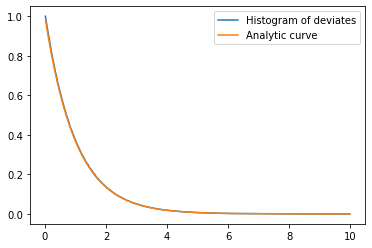

In [12]:
# rejection method using a power-law distribution
def power_sample(n, alpha = 2):
    r = np.random.rand(n)
    return 1./(1.-r)**(1/(alpha-1))-1.

def exp_sample_from_pl(x): # x is an array of power-law deviates
    prob = exp_pdf(x)/power_pdf(x)
    c = np.max(prob)
    prob = prob/c
    accepted = np.random.rand(len(x)) < prob
    print('Acceptance rate =', '%.3f'% np.mean(accepted) )
    return x[accepted]

pls = power_sample(n)
es2 = exp_sample_from_pl(pls)
h, b = np.histogram(es2[np.abs(es2) < 10], 300)
x = 0.5*(b[1:]+b[:-1])
plt.plot(x, h/h.max(), label = 'Histogram of deviates')
plt.plot(x, exp_pdf(x), label = 'Analytic curve')
plt.legend()
plt.show()

So using the power-law is a bit more effecient than using the Lorentzian. Power-laws with a different alpha are much less efficient (the shape of the curve deviates stronger from the exponential).  

### Problem 3
Ratio of uniforms:


$0 \leq u \leq \sqrt{P(v/u)} = exp(-\frac{1}{2} \frac{v}{u})$


$\ln u \leq -\frac{1}{2} \frac{v}{u} $

=> $v \leq -2 u \ln u$ and $v \geq 0$ as the PDF is defined for non-negative argument.


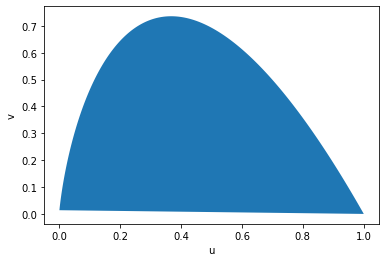

Maximal v = 0.7358


In [13]:
uu = np.linspace(0,1,1001)[1:]
vv = -2*uu*np.log(uu)
plt.fill(uu,vv)
plt.xlabel('u')
plt.ylabel('v')
plt.show()
print('Maximal v =', '%.4f'%np.max(vv))

So the limits on $v$ are $0 \leq v \lesssim 0.736 $

Acceptance rate (of ratios v/u) = 0.679


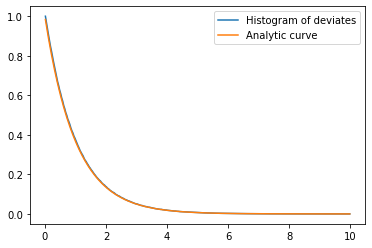

In [14]:
n = 10**7
u = np.random.rand(n)
v = (0.736*np.random.rand(n))
ratio = v/u 
accepted = u < np.exp(-0.5*ratio)
print('Acceptance rate (of ratios v/u) =', '%.3f'% np.mean(accepted))
exp_sample = ratio[accepted]
h, b = np.histogram(exp_sample[np.abs(exp_sample) < 10], 300)
x = 0.5*(b[1:]+b[:-1])
plt.plot(x, h/h.max(), label = 'Histogram of deviates')
plt.plot(x, exp_pdf(x), label = 'Analytic curve')
plt.legend()
plt.show()

It is worth noting that each accepted ratio is produced by generating two uniform deviates.  